In [2]:
import tensorflow as tf
import numpy as np
import os.path
import joblib
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import os
import shutil
import glob
import random

def copy_files_70_30_percent():
    os.chdir(os.path.dirname(os.path.abspath('model_alzheimers_cnn.ipynb')))
    
    if os.path.isdir('model_data') is False:
        os.makedirs('model_data/train/axial/AD')
        os.makedirs('model_data/train/coronal/AD')
        os.makedirs('model_data/train/sagittal/AD')
        os.makedirs('model_data/train/axial/CN')
        os.makedirs('model_data/train/coronal/CN')
        os.makedirs('model_data/train/sagittal/CN')
        os.makedirs('model_data/train/axial/MCI')
        os.makedirs('model_data/train/coronal/MCI')
        os.makedirs('model_data/train/sagittal/MCI')
        os.makedirs('model_data/valid/axial/AD')
        os.makedirs('model_data/valid/coronal/AD')
        os.makedirs('model_data/valid/sagittal/AD')
        os.makedirs('model_data/valid/axial/CN')
        os.makedirs('model_data/valid/coronal/CN')
        os.makedirs('model_data/valid/sagittal/CN')
        os.makedirs('model_data/valid/axial/MCI')
        os.makedirs('model_data/valid/coronal/MCI')
        os.makedirs('model_data/valid/sagittal/MCI')
        
        # get current directory
        print(os.getcwd())
        for view in ['axial', 'coronal', 'sagittal']:
            # os.chdir('../')
            all_ad_files = glob.glob(f'Processed_MRI/augmented/AD/{view}/*')
            all_cn_files = glob.glob(f'Processed_MRI/augmented/CN/{view}/*')
            all_mci_files = glob.glob(f'Processed_MRI/augmented/MCI/{view}/*')
            
            print(len(all_ad_files))

            num_ad_files = len(all_ad_files)
            num_cn_files = len(all_cn_files)
            num_mci_files = len(all_mci_files)

            num_ad_train = int(0.7 * num_ad_files)
            num_cn_train = int(0.7 * num_cn_files)
            num_mci_train = int(0.7 * num_mci_files)

            ad_train_files = random.sample(all_ad_files, num_ad_train)
            cn_train_files = random.sample(all_cn_files, num_cn_train)
            mci_train_files = random.sample(all_mci_files, num_mci_train)

            ad_valid_files = list(set(all_ad_files) - set(ad_train_files))
            cn_valid_files = list(set(all_cn_files) - set(cn_train_files))
            mci_valid_files = list(set(all_mci_files) - set(mci_train_files))

            # print(os.getcwd())
            # os.chdir('code')
            for c in ad_train_files:
                shutil.copy(c, f'model_data/train/{view}/AD')
            for c in cn_train_files:
                shutil.copy(c, f'model_data/train/{view}/CN')
            for c in mci_train_files:
                shutil.copy(c, f'model_data/train/{view}/MCI')

            for c in ad_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/AD')
            for c in cn_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/CN')
            for c in mci_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/MCI')


In [4]:
copy_files_70_30_percent()

In [5]:
train_path = 'model_data/train/sagittal'
valid_path = 'model_data/valid/sagittal'

## Use the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN','MCI'], shuffle=False)

Found 1350 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [7]:
# assert train_batches.n == 1341
# assert valid_batches.n == 576

In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

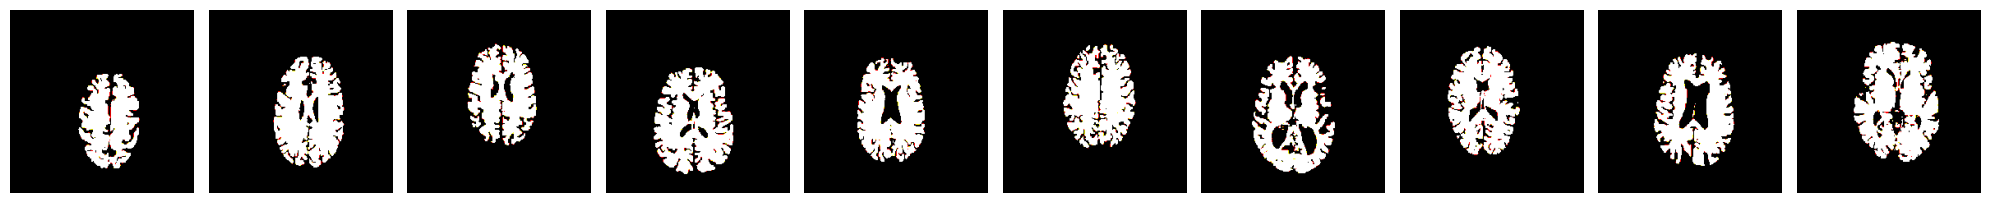

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [10]:
plotImages(imgs)
print(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

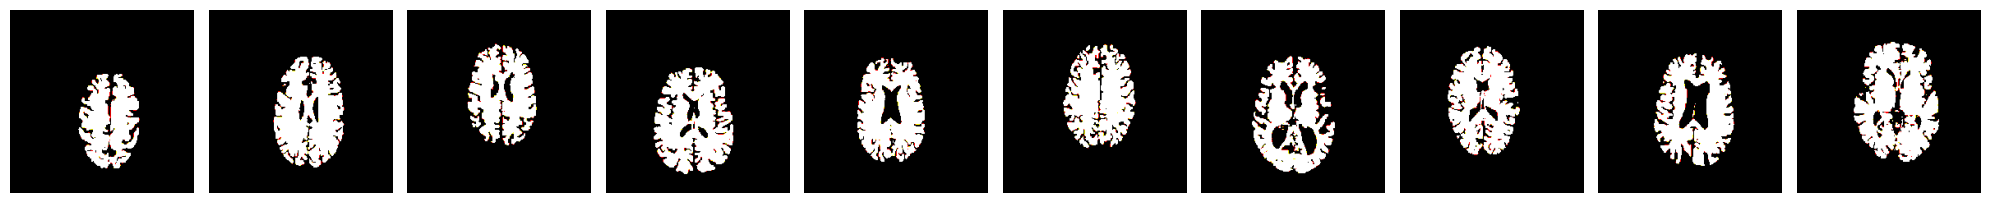

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [11]:
plotImages(imgs)
print(labels)

## Filters

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data.

Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

That is why the number of filters usually increases as the Network gets deeper, even though it doesn't necessarily have to be like that.


## Kernel Size

Convolutional neural networks work on 2 assumptions -

Low level features are local
What's useful in one place will also be useful in other places
Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand.

In one extreme case where we have 1x1 kernels, we are essentially saying low level features are per-pixel, and they don't affect neighbouring pixels at all, and that we should apply the same operation to all pixels.

In the other extreme, we have kernels the size of the entire image. In this case the CNN essentially becomes fully connected, and stops being a CNN, and we are no longer making any assumption on low level feature locality.

In [12]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def residual_block(inputs, num_filters):
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=32)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=64)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=128)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=256)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=512)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.25)(x)
output_tensor = Dense(units=3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

2023-03-13 15:23:16.530259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 15:23:16.530309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-03-13 15:23:16.531096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


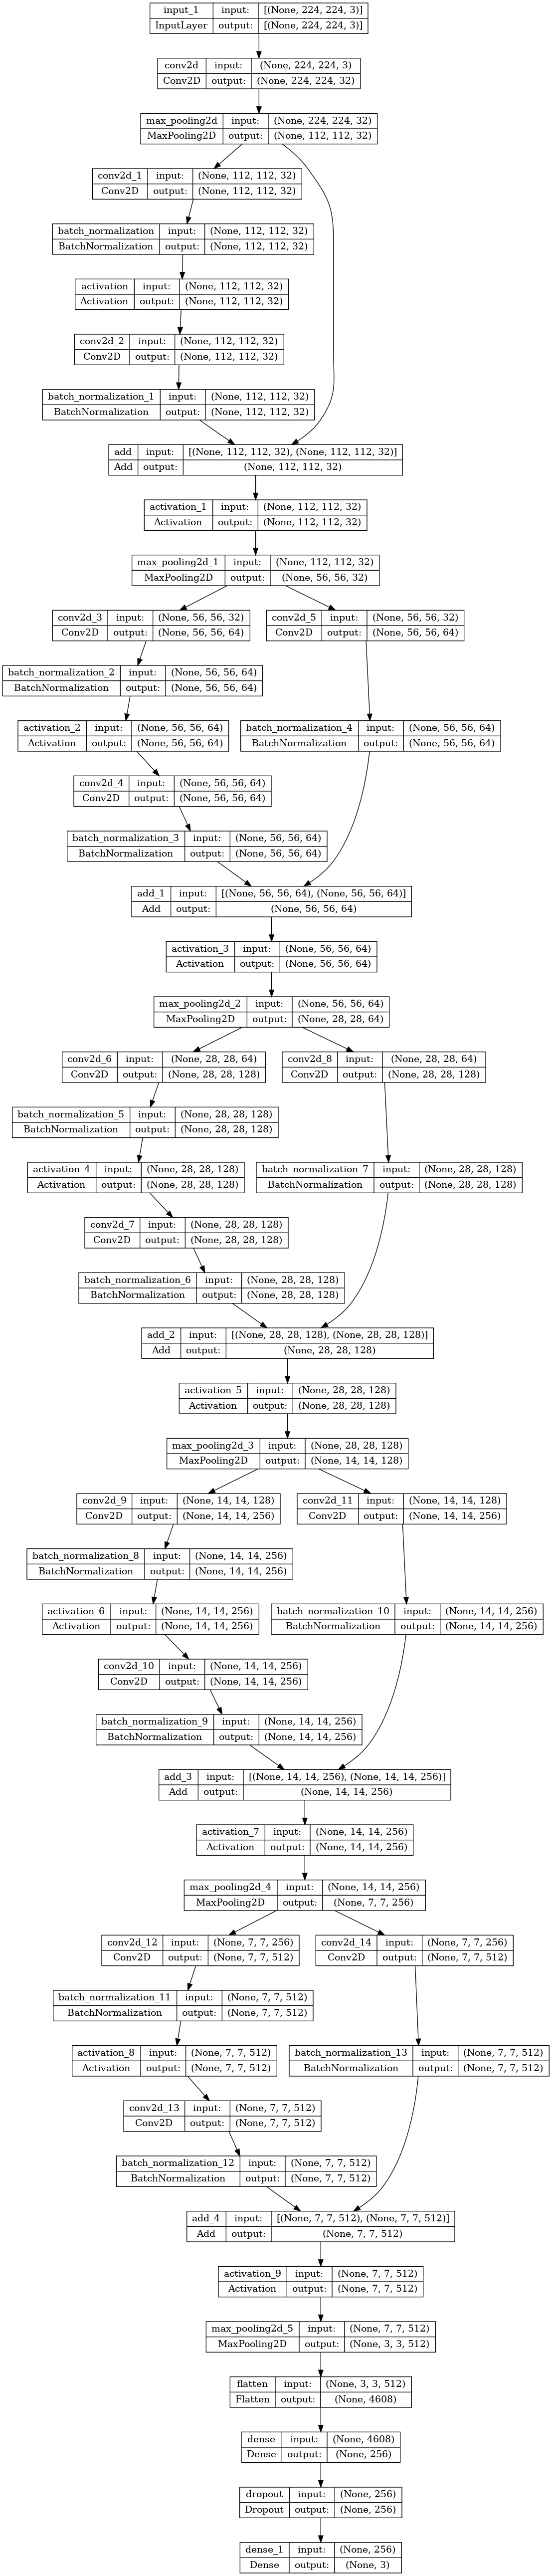

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [73]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 112, 112, 32  0          ['conv2d_30[0][0]']              
 )                              )                                                           

In [74]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
from keras.callbacks import LearningRateScheduler

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 20:
        lr *= 0.1
    return lr

if os.path.isfile('models/simple_model_multi.h5'):
    model = load_model('models/simple_model_multi.h5')
    history = joblib.load('models/history/simple_model_history_multi.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/simple_model_history_multi.pkl')
    
    model.save('models/simple_model_multi.h5')

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-12 22:12:02     73213376
metadata.json                                  2023-03-12 22:12:02           64
config.json                                    2023-03-12 22:12:02        25694
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......activation_6
.........vars
......activation_7
.........vars
......activation_8
.........vars
......activation_9
.........vars
......add
.........vars
......add_1
.........vars
......add_2
.........vars
......add_3
.........vars
......add_4
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalizati

# Tracking Convergence

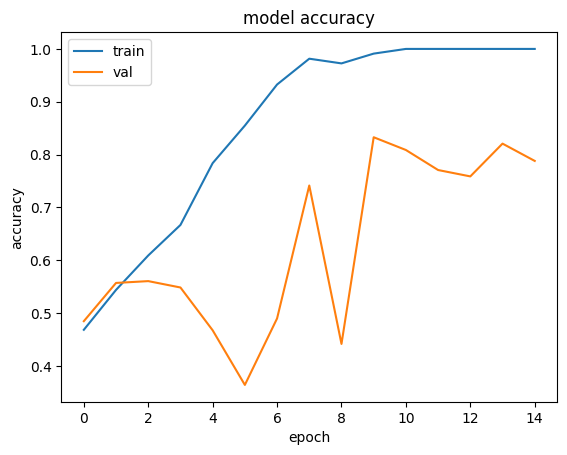

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

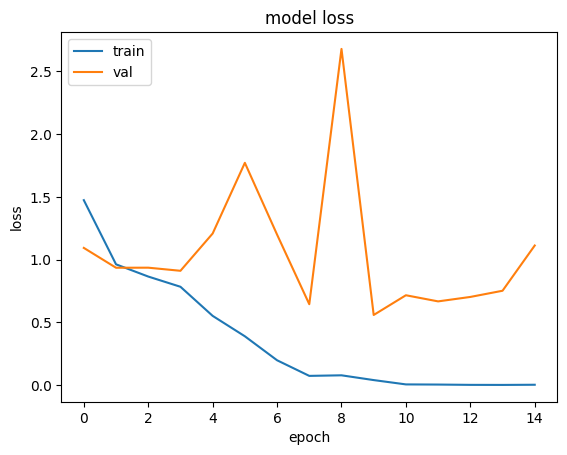

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

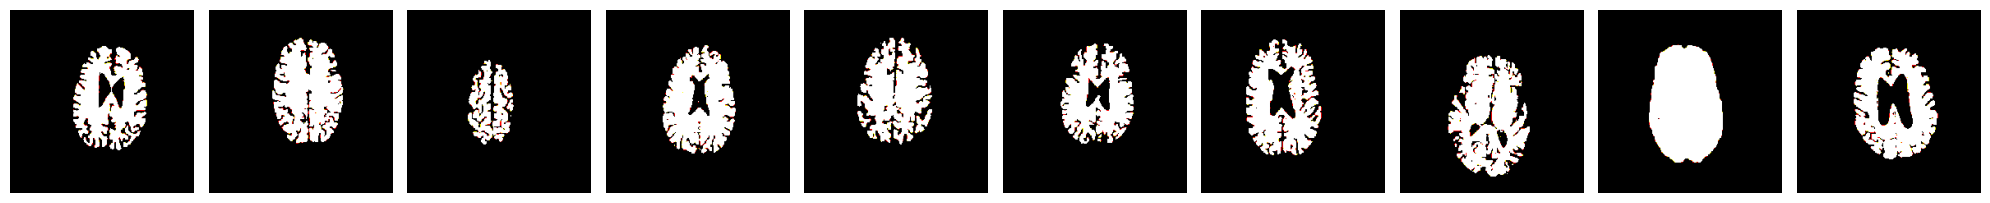

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [52]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

In [53]:
predictions = model.predict(x=valid_batches, verbose=0)

In [54]:
np.round(predictions)

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [55]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
valid_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.68       0.12       0.2       ]
 [0.05172414 0.77011494 0.17816092]
 [0.02135231 0.03914591 0.93950178]]


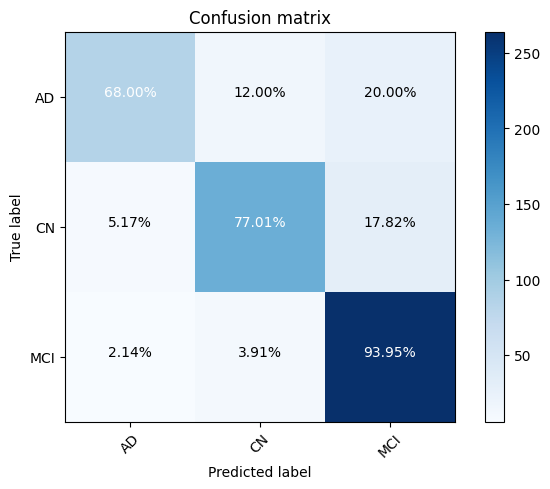

In [58]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

In [59]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

          AD       0.85      0.68      0.76       125
          CN       0.84      0.77      0.80       174
         MCI       0.82      0.94      0.88       281

    accuracy                           0.83       580
   macro avg       0.84      0.80      0.81       580
weighted avg       0.83      0.83      0.83       580

